# (수업) 시계열 자료분석 실습 2

평활법(MA, 단순지수, 이중지수, Holt-Winter)

In [49]:
library('tidyverse')
library('forecast')
library('lmtest')
library('TTR')# SMA
library('data.table')
library('gridExtra')

In [2]:
kings = scan("https://robjhyndman.com/tsdldata/misc/kings.dat", skip = 3) # 영국 왕 수명 데이터

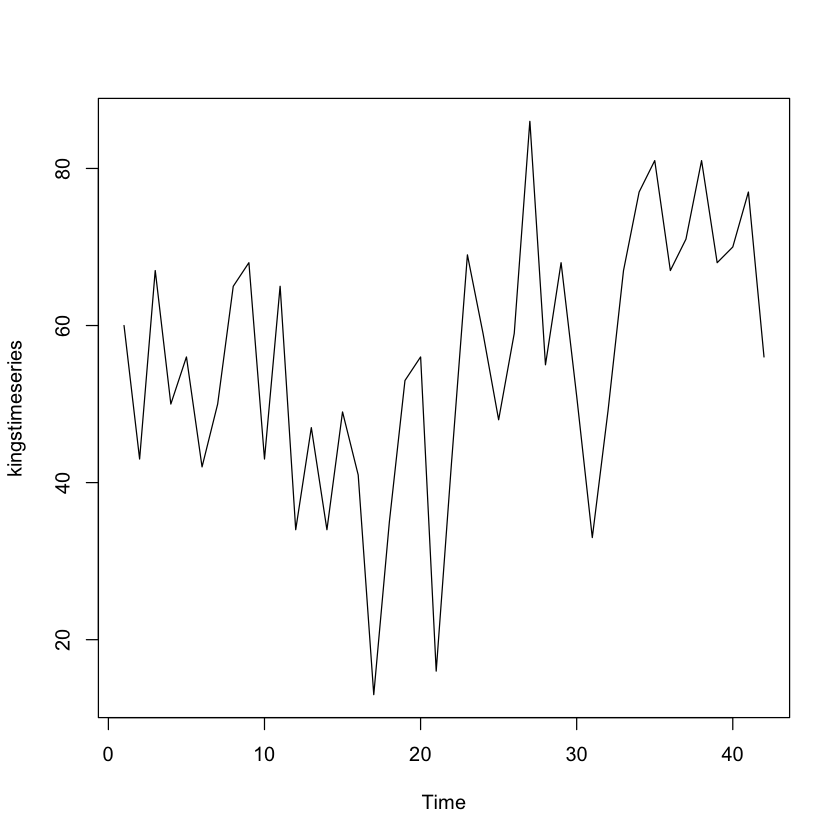

In [3]:
kingstimeseries = ts(kings)
plot.ts(kingstimeseries)

## Moving Average

- 윈도우 크기가 3인 Moving Averages<br>
원래 데이터에 평활한 거 같이 그려짐

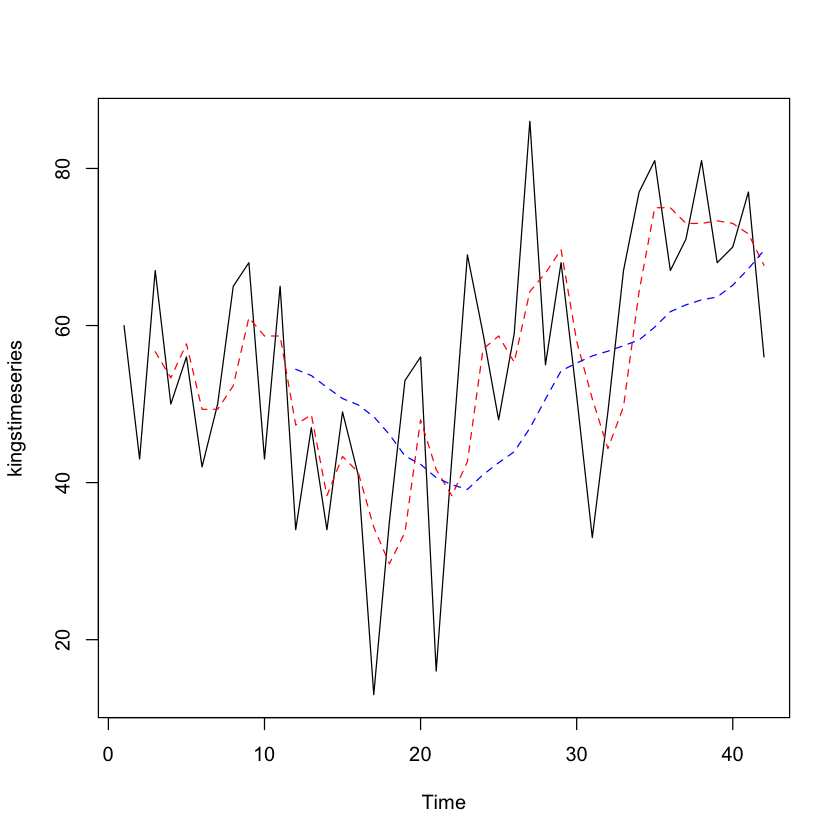

In [4]:
kingstimeseriesSMA3 <- SMA(kingstimeseries, n = 3)
plot.ts(kingstimeseries)
lines(kingstimeseriesSMA3, col = 'red', lty = 2)
lines(SMA(kingstimeseriesSMA3, n = 10), col = 'blue', lty = 2) # window 10개짜리

### 다른 방법으로 그림 그리기

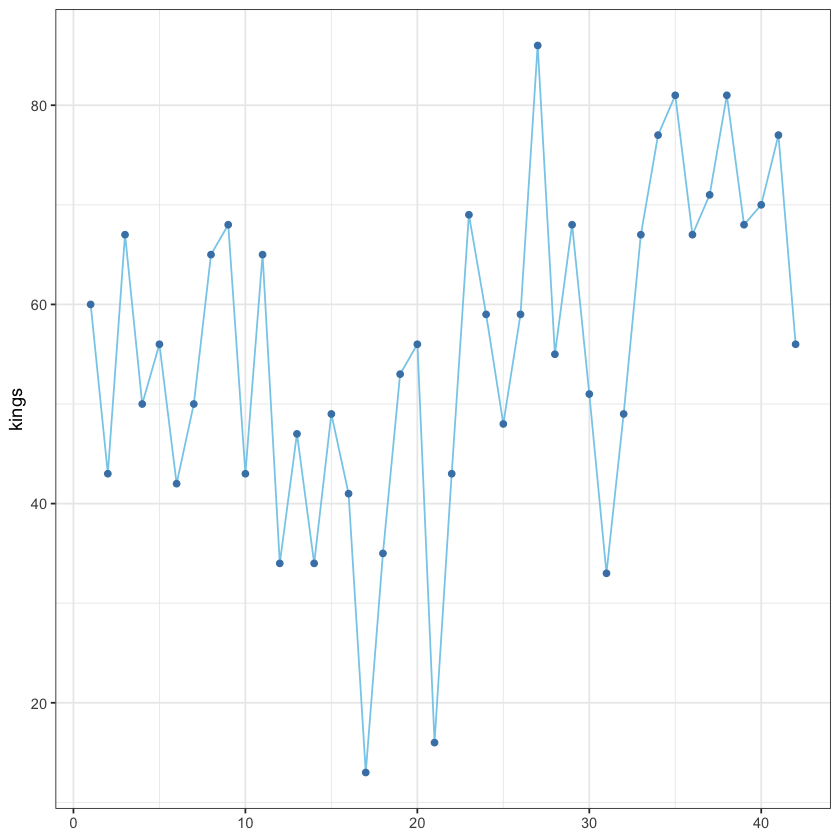

In [5]:
tmp.dat <- data.table(kings = kings,
                      t = 1:length(kings))
tmp.dat[, sma3 := SMA(kingstimeseries, n = 3)]
tmp.dat[, sma10 := SMA(kingstimeseries, n = 10)]

ggplot(tmp.dat, aes(t, kings)) + geom_line(col = 'skyblue') +
geom_point(col = 'steelblue') +
theme_bw() +
theme(axis.title.x = element_blank())

Warning message:
“Removed 11 row(s) containing missing values (geom_path).”


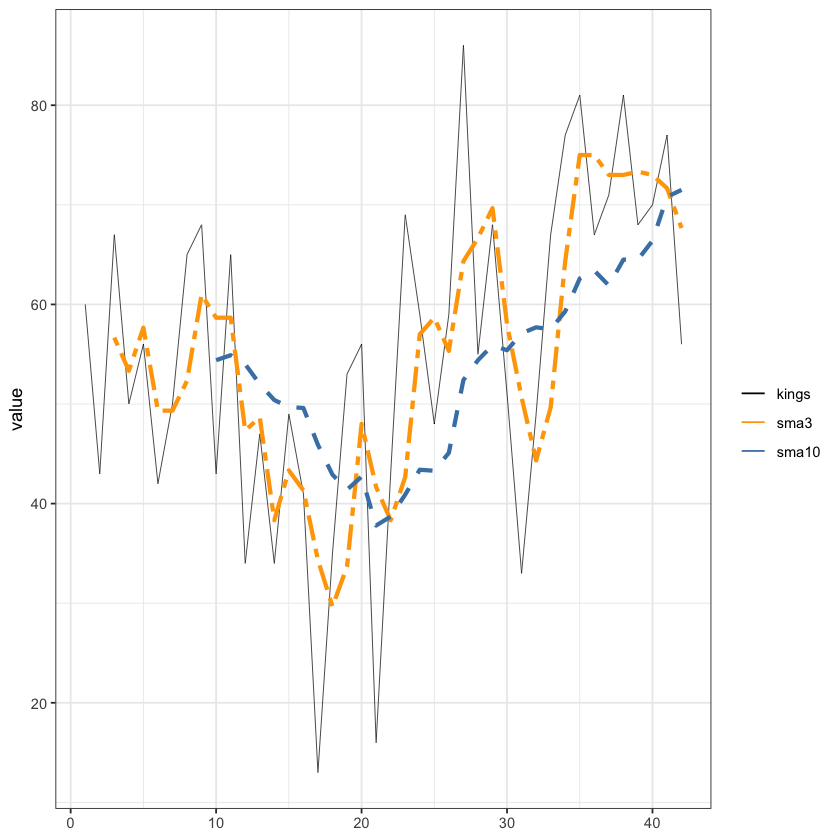

In [6]:
melt.tmp <- melt(tmp.dat, id = 't')

ggplot(melt.tmp, aes(t, value, col = variable, size = variable, lty = variable)) +
geom_line() +
theme_bw() +
labs(col = "") +
scale_linetype_manual(values = c('solid', 'twodash', 'dashed')) +
scale_color_manual(values = c('black', 'orange', 'steelblue')) +
scale_size_manual(values = c(0.2, 1.2, 1.2)) +
guides(lty = 'none', size = 'none') +
theme(axis.title.x = element_blank())

- 모형을 평가하는 수치들<br>
위의 3개는 window를 3개 가져갔을 때의 MSE들<br>
아래 3개는 window를 10개 가져갔을 때의 MSE들

In [7]:
mean((tmp.dat$kings- tmp.dat$sma3)^2, na.rm=T) ##MSE
mean(abs(tmp.dat$kings- tmp.dat$sma3), na.rm=T) ##MAE
mean(abs((tmp.dat$kings- tmp.dat$sma3)/tmp.dat$kings), na.rm=T)*100 ##MAPE

mean((tmp.dat$kings- tmp.dat$sma10)^2, na.rm=T) ##MSE
mean(abs(tmp.dat$kings- tmp.dat$sma10), na.rm=T) ##MAE
mean(abs((tmp.dat$kings- tmp.dat$sma10)/tmp.dat$kings), na.rm=T)*100 ##MAPE

[1] 128.7528

[1] 9.025

[1] 22.47399

[1] 229.22

[1] 12.52727

[1] 31.8798

- 다른 자료

In [8]:
z <- scan('mindex.txt')
mindex <- ts(z, start = c(1986, 1), frequency = 12)
mindex

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1986,9.3,10.7,13.3,14.1,17.8,18.1,19.4,18.8,19.1,18.4,18.0,17.0
1987,19.5,20.1,19.4,15.7,15.6,16.1,14.9,16.0,14.6,18.3,18.2,23.0
1988,22.2,22.1,18.8,17.7,13.8,12.7,16.5,15.6,16.3,10.7,10.4,7.0
1989,4.7,4.5,4.0,6.0,6.2,5.7,4.4,4.2,5.0,5.8,6.4,4.9
1990,7.9,8.2,11.8,10.0,11.1,11.7,12.4,15.2,14.0,15.2,12.9,18.0
1991,14.4,12.7,8.3,11.5,11.9,11.6,10.3,8.5,11.6,12.3,14.5,11.1
1992,11.8,12.4,12.7,9.8,10.0,10.2,9.6,6.9,5.3,4.8,4.6,1.9
1993,3.8,4.7,7.7,7.0,7.2,7.8,8.6,11.4,10.7,11.8,11.3,16.0
1994,13.2,12.0,8.5,11.4,,,,,,,,


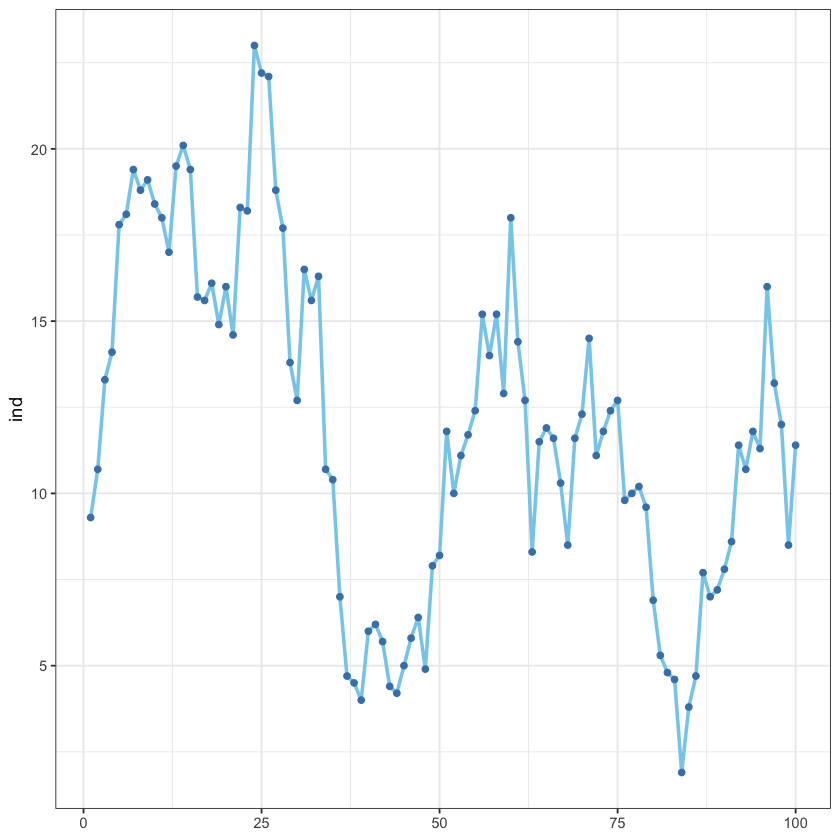

In [9]:
tmp.dat <- data.table(ind = z,
                      t = 1:length(z))

tmp.dat[, sma3 := SMA(mindex, n = 3)]
tmp.dat[, sma10 := SMA(mindex, n = 10)]

ggplot(tmp.dat, aes(t, ind)) + geom_line(col = 'skyblue', size = 1) +
geom_point(col = 'steelblue') +
theme_bw() +
theme(axis.title.x = element_blank())

- window 3개, 10개 나눠서 합쳐서 그리기

## 단순 지수 평활법

day,ind
<date>,<dbl>
1986-01-01,9.3
1986-02-01,10.7
1986-03-01,13.3
1986-04-01,14.1
1986-05-01,17.8
1986-06-01,18.1


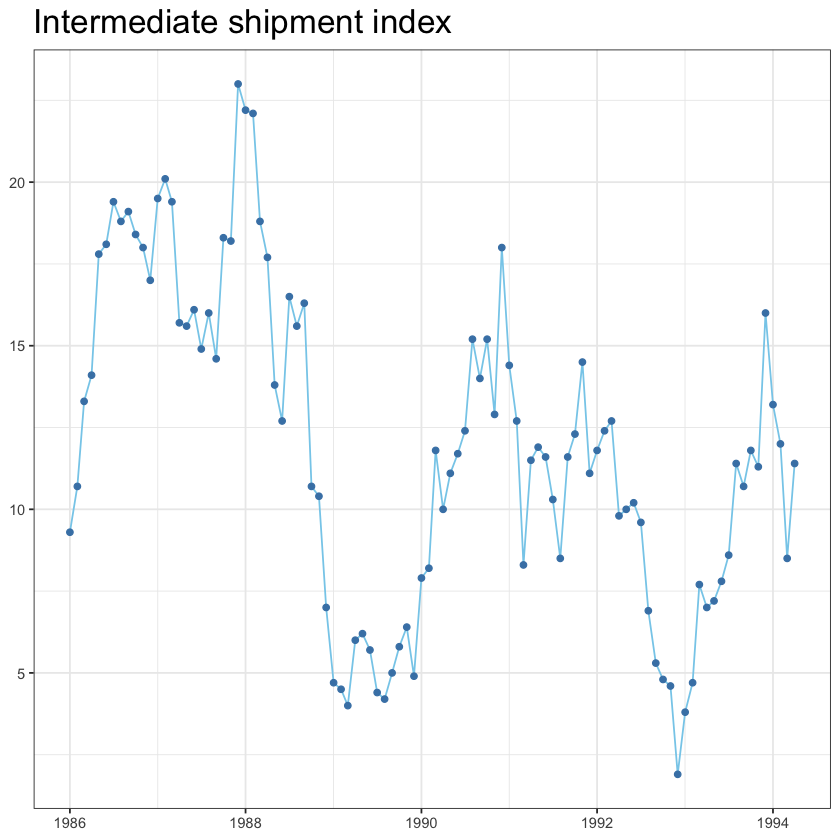

In [10]:
z <- scan("mindex.txt")

mindex <- ts(z, start = c(1986, 1), frequency = 12)

tmp.dat <- data.table(day = seq.Date(as.Date("1986-01-01"), 
                                     by='month', 
                                     length.out=length(z)),
                      ind = z)
head(tmp.dat)

ggplot(tmp.dat, aes(day, ind))+geom_line(col='skyblue') +
  geom_point(col='steelblue')+
  ggtitle("Intermediate shipment index")+
  theme_bw()+
  theme(plot.title = element_text(size=20),
        axis.title = element_blank())

- 평균 = level이라 표현함<br>
예를 들어) 상수평균모형같은 경우 level이 시간에 상관없이 일정하다.<br>
단순지수평활에서는 level이 국지적으로 비슷하지만 전체적으로 보면 변화한다.<br>
alpha가 level을 평활할 때 쓰는 평활상수의미

In [11]:
### 단순지수평활 alpha=0.9

- HoltWinters는 단순지수, 이중지수, 계절평활 3가지 다 가능<br>
이번에는 단순지수평활이라 기울기, 계절성분을 안 쓸거라서 FALSE해줬음.

In [12]:
fit0 <- HoltWinters(mindex, 
                    alpha = 0.9, # 레벨
                    beta = FALSE, # 기울기에 대한 평활상수
                    gamma = FALSE) # 계절성분에 대한 평활상수
ls(fit0) # 어떤 정보 값들 가지는 지 보여줌

[1] "alpha"        "beta"         "call"         "coefficients" "fitted"      
[6] "gamma"        "seasonal"     "SSE"          "x"

- 그 중에서 SSE 보고싶어서 SSE 선택

In [13]:
fit0$SSE

[1] 437.6361

- ses는 단순지수 평활만 사용가능

In [14]:
fit01 <- ses(mindex, 
             alpha = 0.9, # 사실 알파 안써도 얘가 적당히 넣어주긴함
             initial = 'simple',
             h = 10) # 앞으로 몇 개 더 예측해줄지 개수 설정
ls(fit01)

[1] "fitted"    "level"     "lower"     "mean"      "method"    "model"    
 [7] "residuals" "series"    "upper"     "x"

In [15]:
summary(fit01)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = mindex, h = 10, initial = "simple", alpha = 0.9) 

  Smoothing parameters:
    alpha = 0.9 

  Initial states:
    l = 9.3 

  sigma:  2.092
Error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.02051593 2.091975 1.614844 -2.575694 16.57215 0.2947652
                    ACF1
Training set -0.01462494

Forecasts:
         Point Forecast    Lo 80    Hi 80       Lo 95    Hi 95
May 1994       11.14643 8.465459 13.82741  7.04623710 15.24663
Jun 1994       11.14643 7.539551 14.75332  5.63018345 16.66268
Jul 1994       11.14643 6.806897 15.48597  4.50968590 17.78318
Aug 1994       11.14643 6.181200 16.11167  3.55276359 18.74010
Sep 1994       11.14643 5.625970 16.66690  2.70361248 19.58925
Oct 1994       11.14643 5.121693 17.17117  1.93238821 20.36048
Nov 1994       11.14643 4.656482 17.63638  1.22090910 21.07196
Dec 1994       11.1464

- 해석 : ME, RMSE ... 등 알려줌.<br>
Forecasts 보면 Point Forecast는 점 추정량으로서 각각의 level에 대한 예측값<br>
그 옆은 80% 신뢰수준으로 상한, 하한<br>
또 그 옆은 95% 신뢰수준으로 상한, 하한을 나타낸다.<br>
참고) Point Forecast가 전부 같은 값으로 나오는 이유는 예를 들어 100번째 데이터까지를 바탕으로 결과를 도출한다면<br>
어짜피 100개의 결과를 바탕으로 예측한 것이기에 바뀔 이유가 없다.<br>
하지만 신뢰구간은 시간이 지날수록 믿을 수 없는 값이 많아지기 때문에(변동 증가) 시간이 지남에 따라 구간이 커진다.

- holt는 이중지수 평활에서 사용

In [16]:
fit02 <- holt(mindex, 
              alpha = 0.9,
              beta=0, # 기울기
              phi=0,
              initial ='simple',
              h = 10)
ls(fit02)

[1] "fitted"    "level"     "lower"     "mean"      "method"    "model"    
 [7] "residuals" "series"    "upper"     "x"

In [17]:
summary(fit02)


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(y = mindex, h = 10, initial = "simple", alpha = 0.9, beta = 0,  

 Call:
     phi = 0) 

  Smoothing parameters:
    alpha = 0.9 
    beta  = 0 
    phi   = 0 

  Initial states:
    l = 9.3 
    b = 1.4 

  sigma:  2.092
Error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.02051593 2.091975 1.614844 -2.575694 16.57215 0.2947652
                    ACF1
Training set -0.01462494

Forecasts:
         Point Forecast    Lo 80    Hi 80       Lo 95    Hi 95
May 1994       11.14643 8.465459 13.82741  7.04623710 15.24663
Jun 1994       11.14643 7.539551 14.75332  5.63018345 16.66268
Jul 1994       11.14643 6.806897 15.48597  4.50968590 17.78318
Aug 1994       11.14643 6.181200 16.11167  3.55276359 18.74010
Sep 1994       11.14643 5.625970 16.66690  2.70361248 19.58925
Oct 1994       11.14643 5.121693 17.17117  1.93238821 20.36048
Nov 1994       11.14643 4.656482 17.6

- 해석: HoltWinters의 경우 원래 Point Forecast의 첫 칸 비워져서 나오는데 여기서는 0을 일부러 넣어서 칸 맞춤<br>

In [18]:
fit_data <- data.table(
  fit_HoltWinters = c(0,fit0$fitted[,'xhat']),
  fit_ses = fit01$fitted,
  fit_holt = fit02$fitted
)

head(fit_data)

fit_HoltWinters,fit_ses,fit_holt
<dbl>,<ts>,<ts>
0.00000,9.30000,9.30000
9.30000,9.30000,9.30000
10.56000,10.56000,10.56000
13.02600,13.02600,13.02600
13.99260,13.99260,13.99260
17.41926,17.41926,17.41926


### 여러 평할지수에 따른 변화

- 평활지수 0.2, 0.9썼을 때 평활이 얼마나 달라지나?

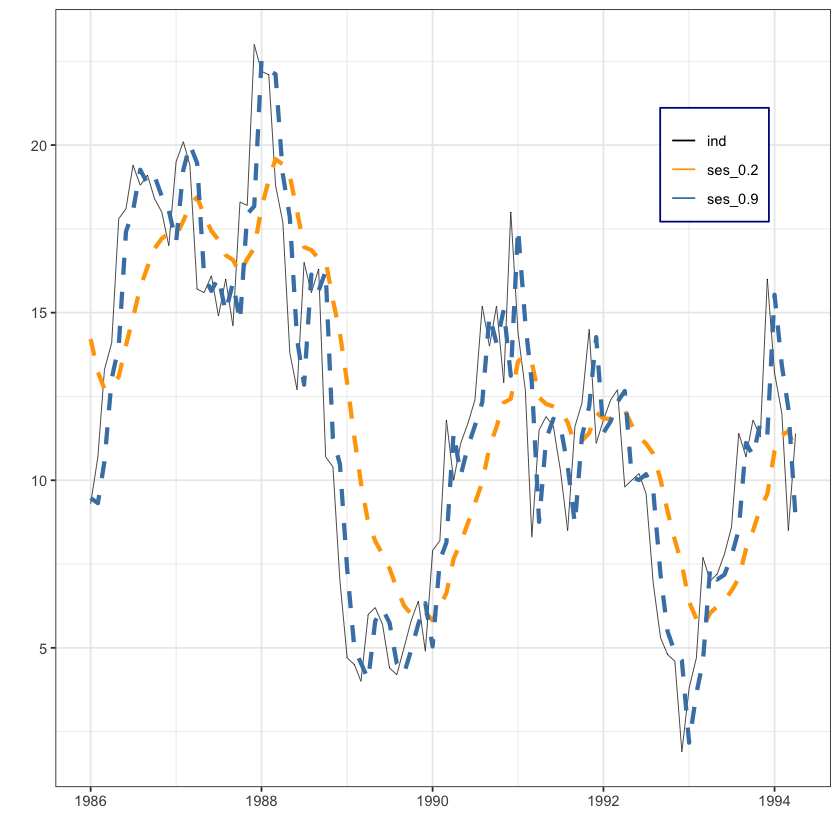

In [19]:
tmp.dat[, ses_0.2 := ses(mindex, alpha = 0.2)$fitted]
tmp.dat[, ses_0.9 := ses(mindex, alpha = 0.9)$fitted]

melt.tmp <- melt(tmp.dat, id='day')

ggplot(melt.tmp, aes(day, value, col=variable, size=variable, lty=variable))+
  geom_line() +
  xlab("")+ylab("")+
  theme_bw()+
  scale_linetype_manual(values=c('solid',"dashed","dashed" ))+
  scale_color_manual(values=c('black','orange', 'steelblue'))+
  scale_size_manual(values=c(0.2,1.2,1.2))+
  guides(lty = 'none', size='none')+
  theme(legend.position = c(0.85,0.8)) +
  theme(legend.background = element_rect(linetype="solid", 
                                         colour ="darkblue"))+
  theme(legend.title = element_blank())

#### 최적 평활상수 구하기 

- 최적의 평활상수 = SSE를 최소화 시켜주는 값

In [20]:
w <-c(seq(0.1,0.8,0.1), 
      seq(0.81, 0.99, 0.01)) # weight

sse <- sapply(w, function(x) 
  return(sum(ses(mindex, alpha = x)$residuals^2)))

In [21]:
sse %>% head

[1] 1459.6447 1010.0340  768.2800  630.7295  547.1815  494.6174

In [22]:
w[which.min(sse)]  # 최적 평활상수값
fit1 <- ses(mindex, alpha=w[which.min(sse)], h=6)

[1] 0.9

`-` 예측모형 plot

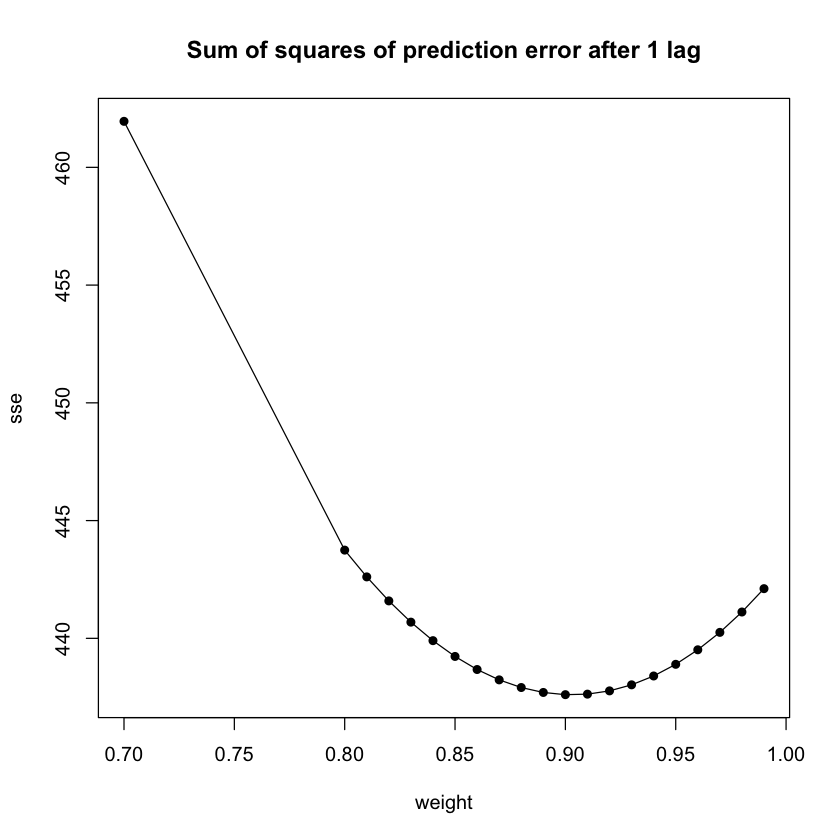

In [23]:
w1 = w[-c(1:6)]  # xaxis from 0.7 to 1.0
sse1 = sse[-c(1:6)]
plot(w1,sse1, type="o", xlab="weight", ylab="sse", pch=16,
     main="Sum of squares of prediction error after 1 lag")

#### 잔차 

In [24]:
t.test(resid(fit1), mu=0)


	One Sample t-test

data:  resid(fit1)
t = 0.088676, df = 99, p-value = 0.9295
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.3985116  0.4357973
sample estimates:
 mean of x 
0.01864288 


- 해당 ses의 잔차 출력한 것에 평균 0인지 t.test검증

1) alpha = 0.9

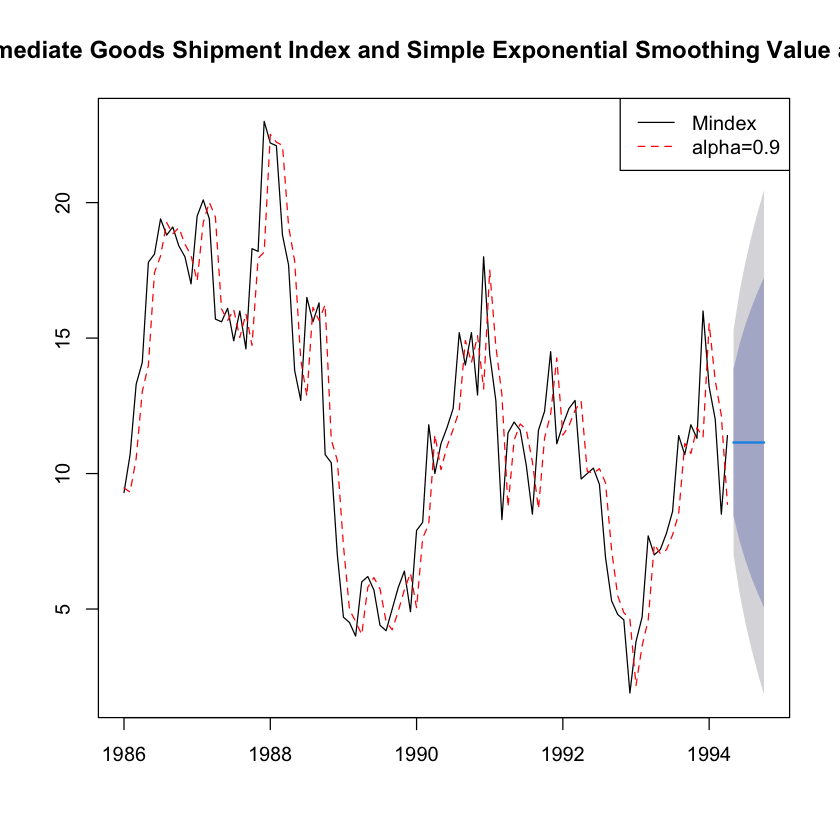

In [25]:
plot(fit1, xlab="", ylab="", 
     main="Intermediate Goods Shipment Index and Simple Exponential Smoothing Value alpha=0.9", 
     lty=1,col="black" )
lines(fitted(fit1), col="red", lty=2)
legend("topright", legend=c("Mindex", "alpha=0.9"), 
       lty=1:2,col=c("black","red"))

- 마지막 보면 파란색 줄로 쭉 이어지는게 더 이상 추가해줄 데이터가 없어서 예측이 같게 이어지는 거임.<br>
하지만 시간이 지남에 따라 신뢰구간은 늘어나기에 범위적으로 늘어나는 표현이 일어남<br>
마지막 자세히 보면 빨간 점선이 검은 선보다 아래에 있다. alpha = 0.9라는 것은 최근 실제 정보를 9만큼, 예측값을 1만큼 내분한 점을 표현하는 것이기에<br>
보면 파란색 줄은 검은선보다 10%정도만큼 살짝 내려온 곳에 위치하게 된다.

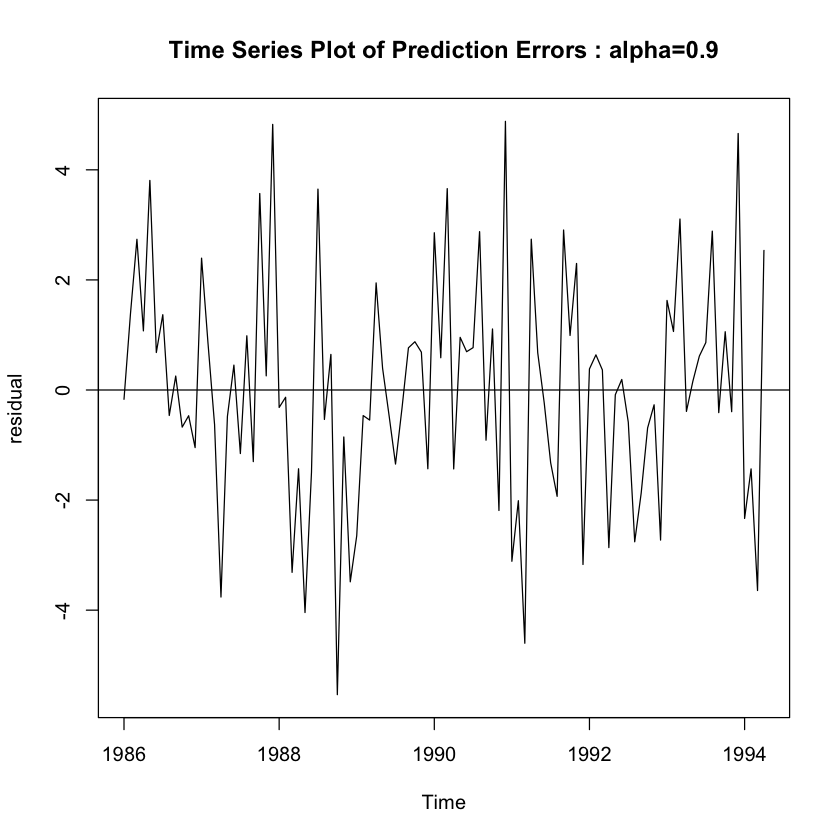

In [26]:
plot(fit1$residuals, ylab="residual",
     main="Time Series Plot of Prediction Errors : alpha=0.9"); abline(h=0)

2) alpha = 0.2

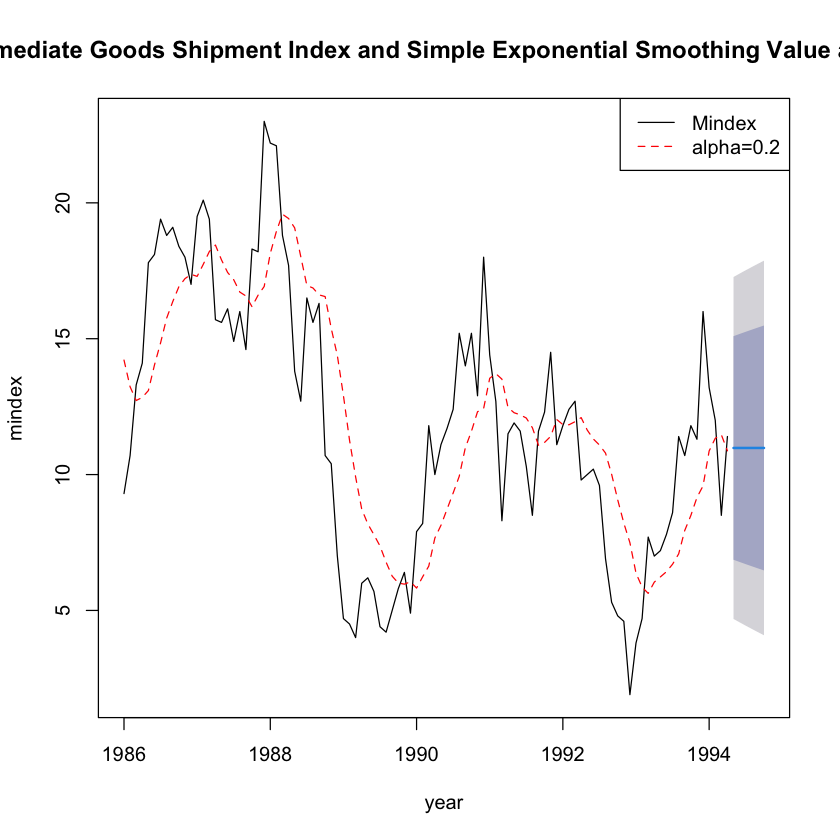

In [27]:
fit2 <- ses(mindex, alpha=0.2, h=6) 
plot(fit2, xlab="year", ylab="mindex", 
     main="Intermediate Goods Shipment Index and Simple Exponential Smoothing Value alpha=0.2", 
     lty=1,col="black")
lines(fitted(fit2), col="red", lty=2)
legend("topright", legend=c("Mindex","alpha=0.2"), 
       lty=1:2,col=c("black","red"))

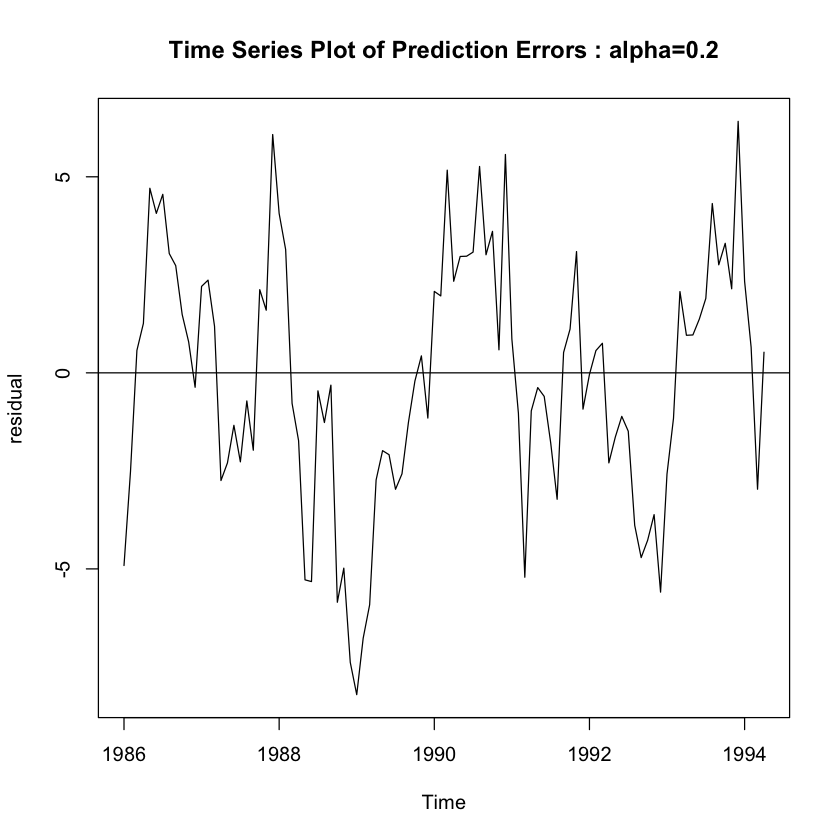

In [28]:
plot(fit2$residuals, ylab="residual",
     main="Time Series Plot of Prediction Errors : alpha=0.2"); abline(h=0)

### 두 모형의 비교

In [29]:
round(rbind(accuracy(fit1), accuracy(fit2)), digit=3)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.019,2.092,1.616,-2.596,16.589,0.295,-0.015
Training set,-0.162,3.178,2.595,-13.104,30.650,0.474,0.736


### 추정된 alpha를 이용한 단순지수평활

In [30]:
fit3 <- ses(mindex,h=6)
fit3$model

Simple exponential smoothing 

Call:
 ses(y = mindex, h = 6) 

  Smoothing parameters:
    alpha = 0.9031 

  Initial states:
    l = 9.4594 

  sigma:  2.1131

     AIC     AICc      BIC 
614.1310 614.3810 621.9466 

- alpha 따로 입력안하면 알아서 최적으로 생각하는 alpha 입력해줌<br>
여기서는 Smoothing parameters : alpha = 0.9031로 해줌.

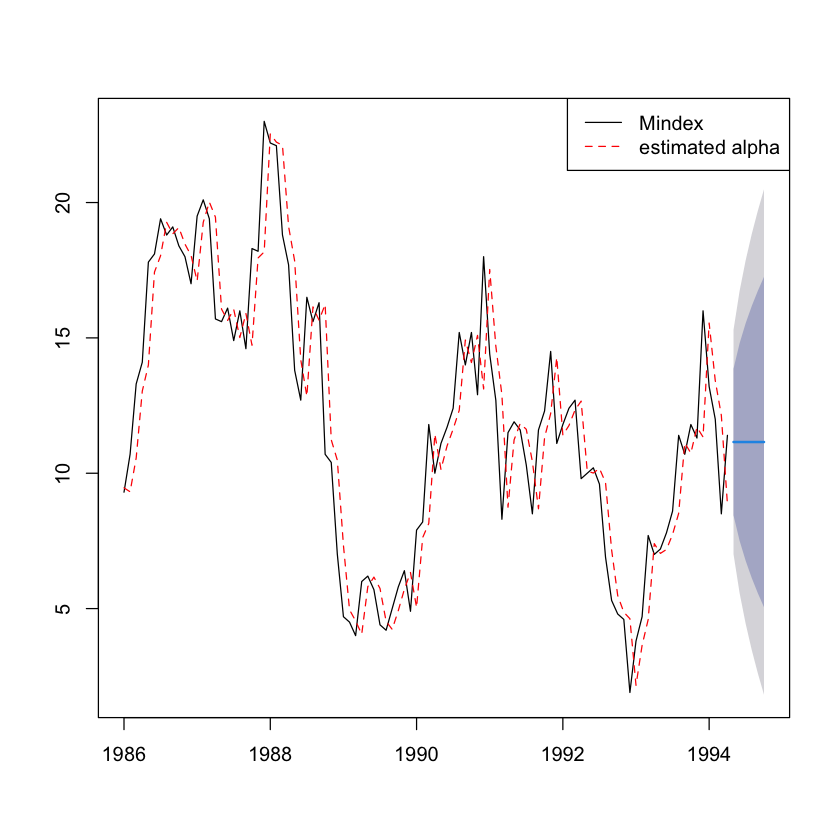

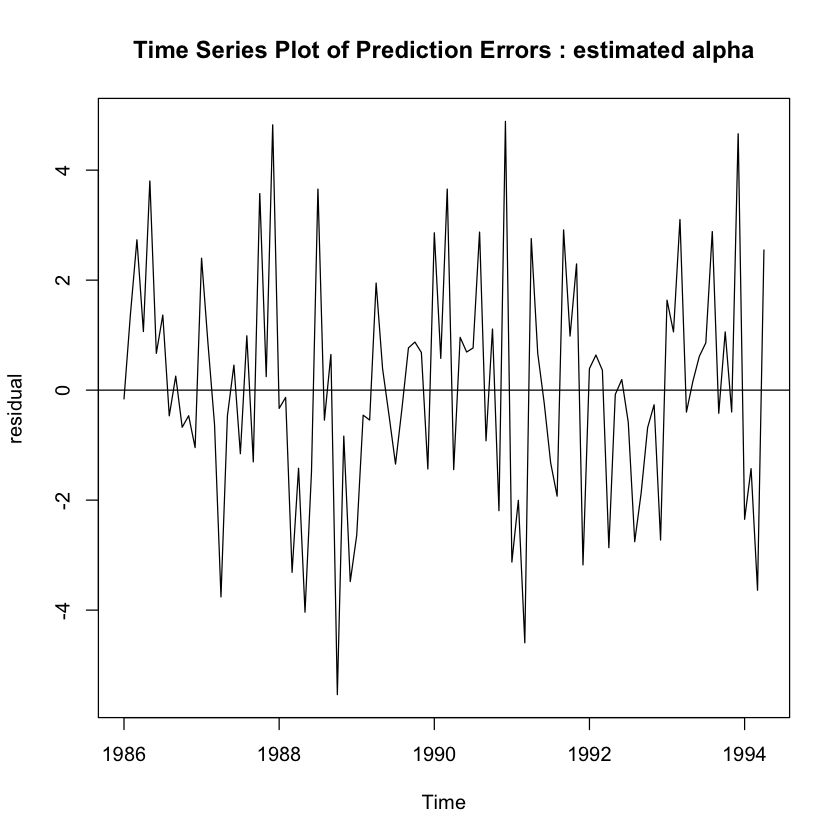

In [31]:
plot(fit3, xlab="", ylab="", main="",
     # main="중간재 출하지수와 단순지수평활값 : alpha estimated", 
     lty=1, col="black")
lines(fit3$fitted, col = "red", lty = 2)
legend("topright", legend=c("Mindex","estimated alpha"), 
       lty=1:2,col=c("black","red"))
plot(fit3$residuals, ylab="residual",  
     main="Time Series Plot of Prediction Errors : estimated alpha"); abline(h=0)

## 이중 지수 평활법

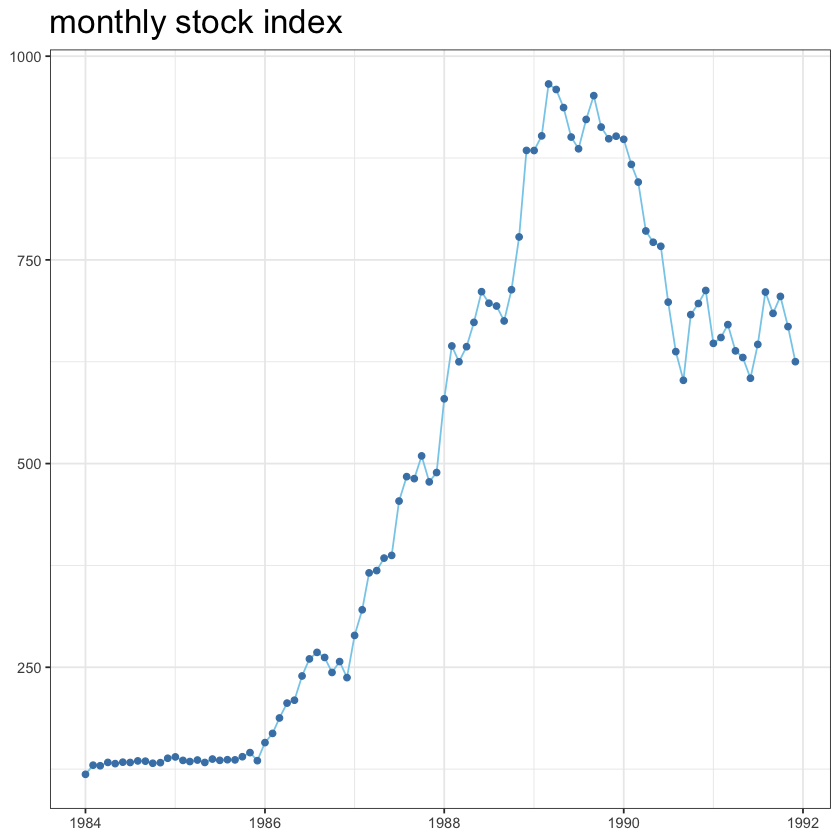

In [32]:
z <- scan("stock.txt") 
stock <- ts(z, start=c(1984,1), frequency=12)

tmp.data <- data.table(
  day = seq.Date(as.Date("1984-01-01"), 
                 by='month', length.out=length(z)),
  z=z  
)

ggplot(tmp.data, aes(day, z)) + geom_line(col='skyblue') +
  geom_point(col='steelblue')+
  # scale_x_date(date_breaks = "1 year", date_labels = "%Y-%m") +
  theme_bw()+ggtitle("monthly stock index")+
  theme(plot.title = element_text(size=20),
        axis.title = element_blank())

- 전체적으로 증가하는 추세라고 볼 수도 있지만 증가하다가 감소하다 다시 잠잠해지는<br>
즉, 일반적인 선형추세모형을 사용하기는 어렵다.

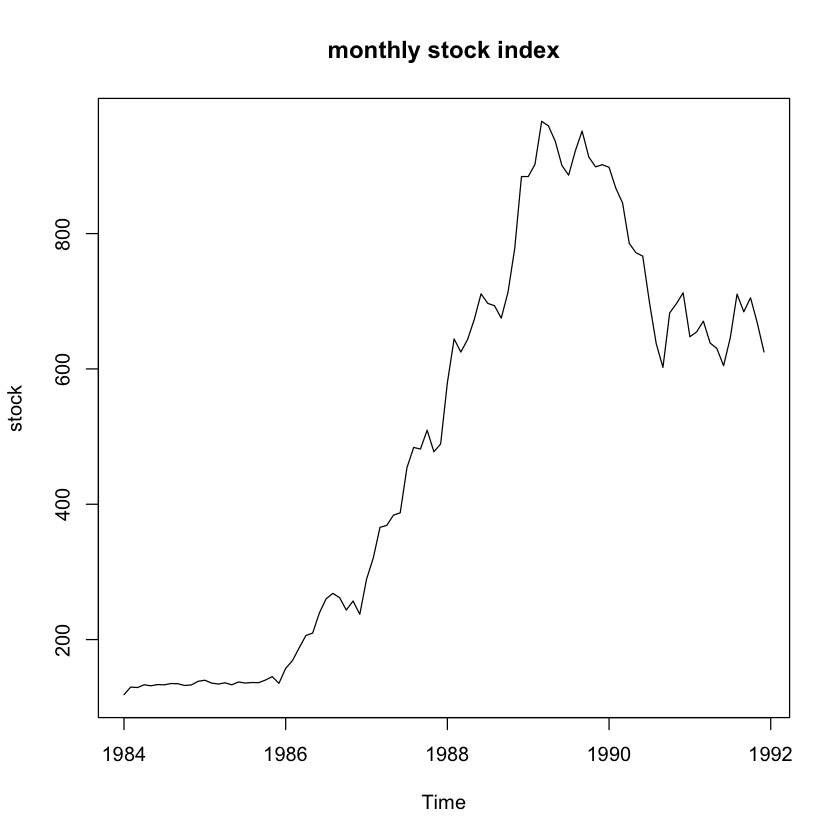

In [33]:
plot.ts(stock, main = 'monthly stock index')

### 1모수 이중지수평활 

- alpha, beta 동일하게 사용하므로 1모수

In [34]:
fit4 = holt(stock, alpha=0.6, beta=0.6, h=6) 
fit4$model

Holt's method 

Call:
 holt(y = stock, h = 6, alpha = 0.6, beta = 0.6) 

  Smoothing parameters:
    alpha = 0.6 
    beta  = 0.6 

  Initial states:
    l = 115.6009 
    b = 6.8098 

  sigma:  40.2546

     AIC     AICc      BIC 
1149.575 1149.836 1157.268 

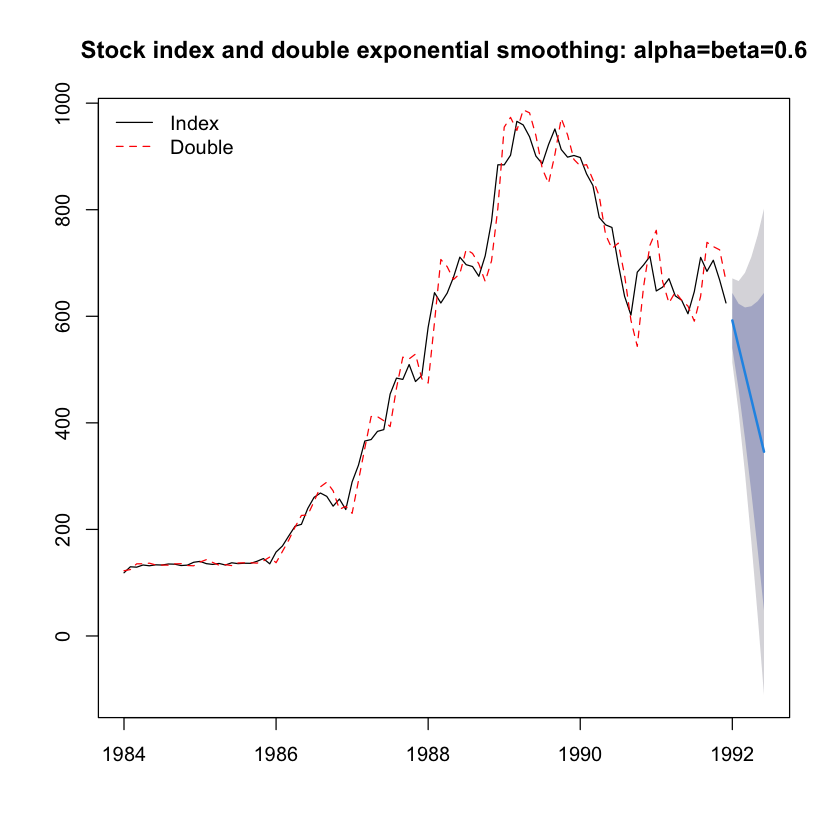

In [35]:
plot(fit4, ylab="", xlab="",  lty=1, col="black",
     main="Stock index and double exponential smoothing: alpha=beta=0.6"
     )
lines(fitted(fit4), col="red", lty=2)
legend("topleft", lty=1:2, col=c("black","red"), c("Index", "Double"), bty = "n")

- 뒤에 예측한 것을 보면 마지막 시점에서 추세가 아래로 내려가고 있으므로 쭉 내려가는 것으로 예측이 된거임.<br>
딱히 예측에 좋은 거 같지는 않음.

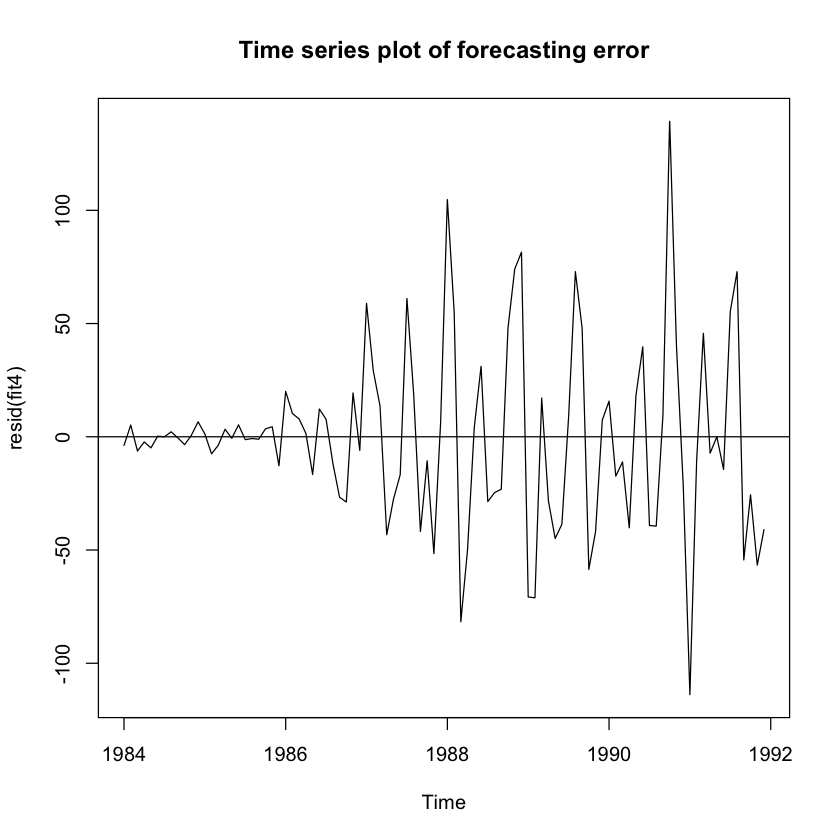

In [36]:
plot(resid(fit4), main="Time series plot of forecasting error"); abline(h=0)

### 이중지수평활 alpha, beta 추정

- alpha, beta 선택하지 않으면 알아서 선택해서 돌려줌.

In [37]:
fit5 = holt(stock, h=6)
fit5$model

Holt's method 

Call:
 holt(y = stock, h = 6) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.1071 

  Initial states:
    l = 124.1137 
    b = 3.4954 

  sigma:  31.8609

     AIC     AICc      BIC 
1108.677 1109.343 1121.498 

- 여기서는 0.999, 0.1로 선택됨.

- beta를 0.6으로 쓸 때보다는 기울기가 훨씬 완만한 모습을 보인다.

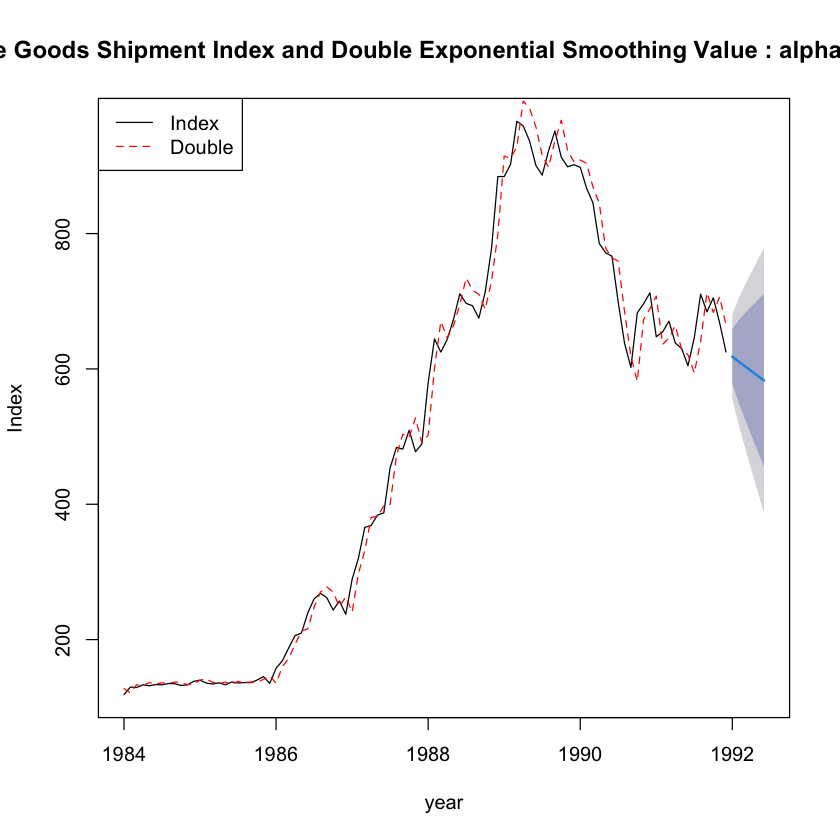

In [38]:
plot(fit5, ylab="Index", xlab="year",  lty=1, col="black",
     main="Intermediate Goods Shipment Index and Double Exponential Smoothing Value : alpha, beta estimated")
lines(fitted(fit5), col="red", lty=2)
legend("topleft", lty=1:2, col=c("black","red"), c("Index", "Double"))

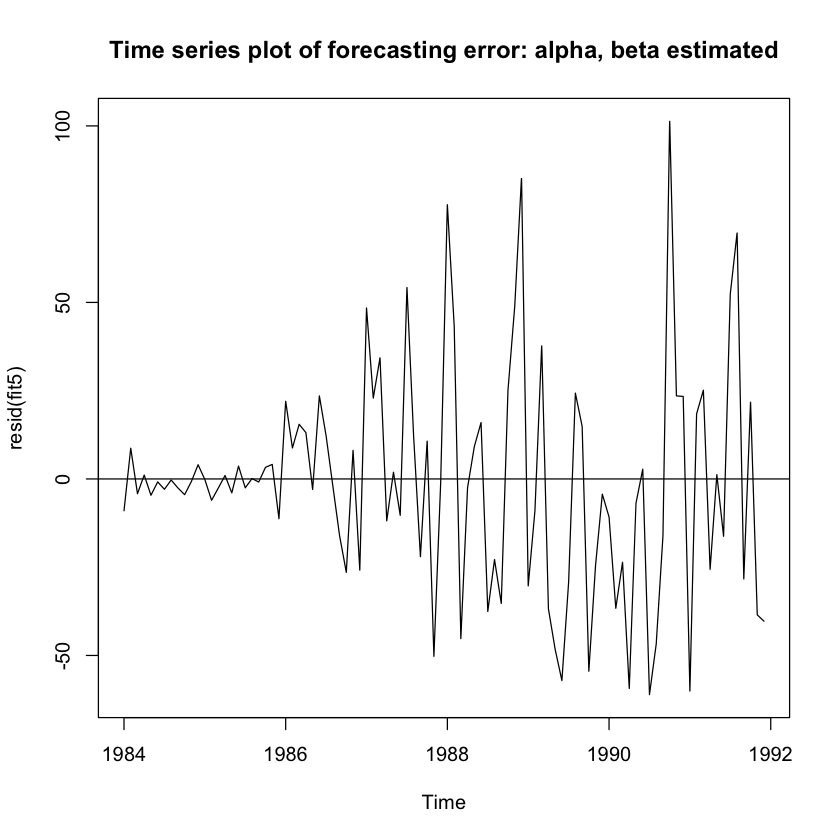

In [39]:
plot(resid(fit5), main="Time series plot of forecasting error: alpha, beta estimated")
abline(h=0)

## Holt-Winters Method(계절)

`-` 항공사 데이터 사용

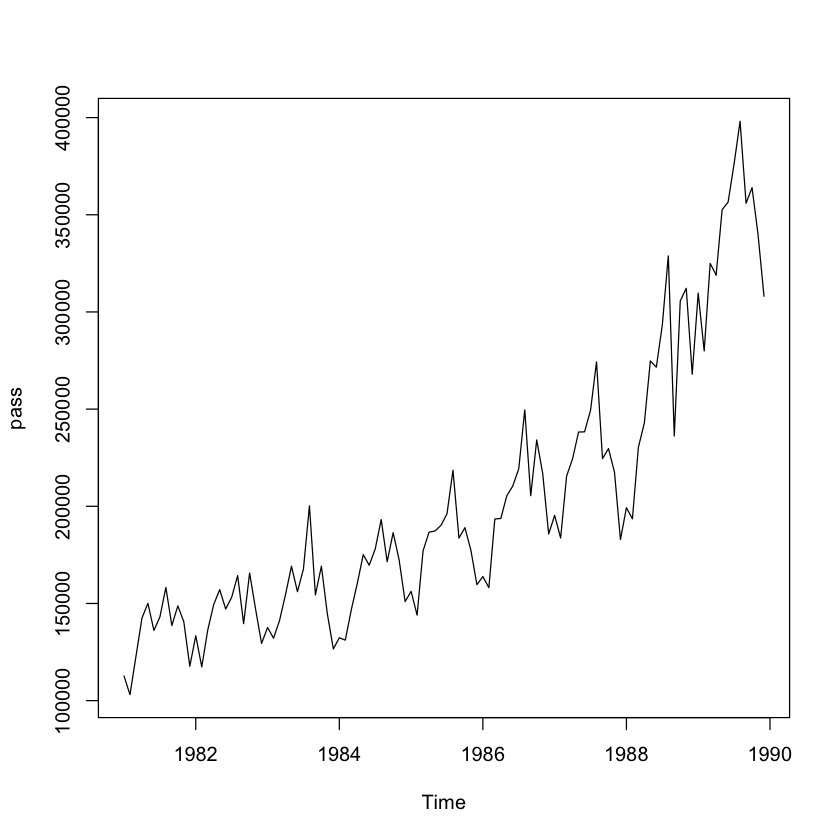

In [40]:
z <- scan("koreapass.txt")
pass <- ts(z, start=c(1981,1), frequency=12) 

plot.ts(pass)

tmp.data <- data.table(
  day = seq.Date(as.Date("1981-01-01"), 
                 by='month', length.out=length(z)),
  z=z  
)

- 보면 분산이 점점 증가하는 형태이기에 평활모형에서 승법모형을 사용해야 한다. or 로그변환한 가법모형사용

### Holt Winters additive model

- 가법이면 `seasonal="additive"`<br>
승법이면 `seasonal="multiplicative"`

In [41]:
fit6 = hw(pass, seasonal="additive", h=12) # 1년 예측이라 12
fit6$model

Holt-Winters' additive method 

Call:
 hw(y = pass, h = 12, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.5963 
    beta  = 0.0177 
    gamma = 1e-04 

  Initial states:
    l = 129763.5823 
    b = 799.4119 
    s = -29016.96 -855.2679 13617.18 -4624.62 37697.04 16768.22
           9720.317 14214.29 317.4589 -5632.175 -31459.7 -20745.79

  sigma:  11509.58

     AIC     AICc      BIC 
2542.155 2548.955 2587.751 

- alpha, beta, gamma 따로 입력하지 않았으므로 알아서 해줌.

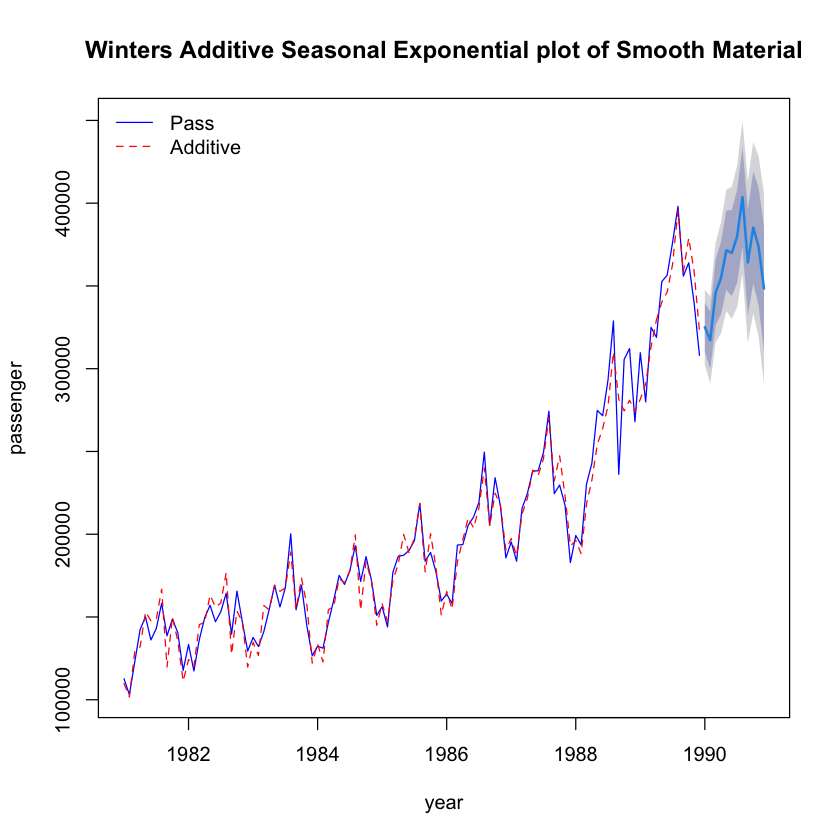

In [42]:
plot(fit6,  ylab="passenger", xlab="year", lty=1, col="blue",
     main="Winters Additive Seasonal Exponential plot of Smooth Material")
lines(fit6$fitted, col="red", lty=2)
legend("topleft", lty=1:2, col=c("blue","red"), c("Pass", "Additive"),  bty = "n")

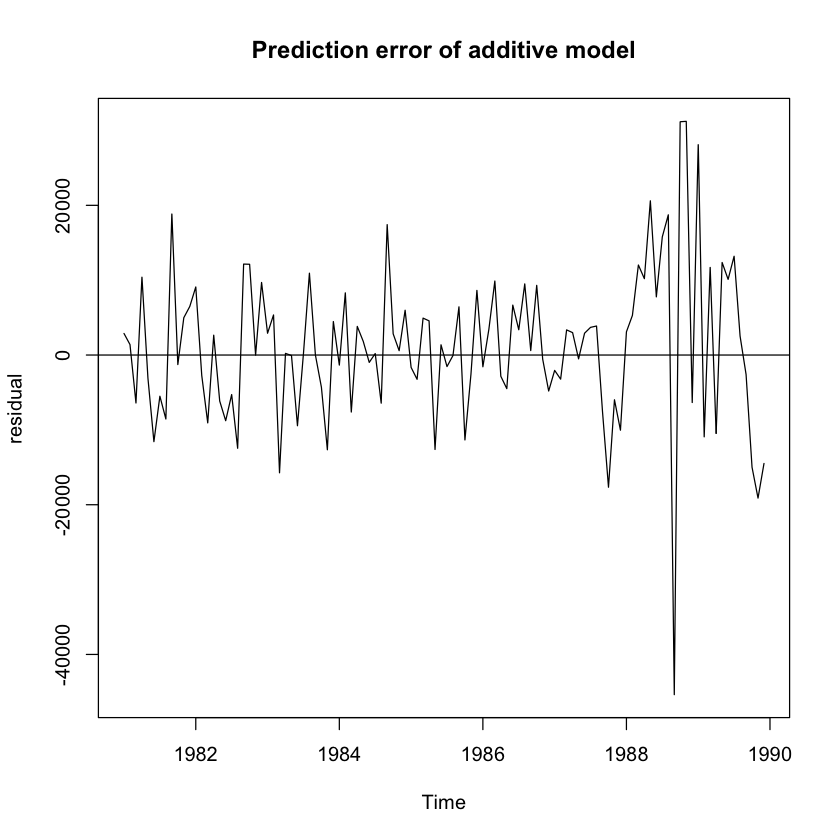

In [43]:
ts.plot(resid(fit6), ylab="residual", 
        main="Prediction error of additive model"); abline(h=0)

In [44]:
dwtest(lm(resid(fit6)~1), alternative = 'two.sided')


	Durbin-Watson test

data:  lm(resid(fit6) ~ 1)
DW = 2.0779, p-value = 0.683
alternative hypothesis: true autocorrelation is not 0


- 더빈왓슨에서 ~1의 형태로 하면 상수평활형태로 결과 나옴.<br>
여튼저튼 잔차 그 자체의 결과로 나오게 됨.

### Holt Winters multiplicative model

In [45]:
fit7= hw(pass, seasonal="multiplicative",h=12) 
fit7$model

Holt-Winters' multiplicative method 

Call:
 hw(y = pass, h = 12, seasonal = "multiplicative") 

  Smoothing parameters:
    alpha = 0.4231 
    beta  = 0.1209 
    gamma = 0.0014 

  Initial states:
    l = 128311.2252 
    b = 914.1471 
    s = 0.8553 0.9918 1.0572 0.9742 1.1913 1.0935
           1.0469 1.0668 0.9952 0.9699 0.8389 0.9189

  sigma:  0.051

     AIC     AICc      BIC 
2506.102 2512.902 2551.699 

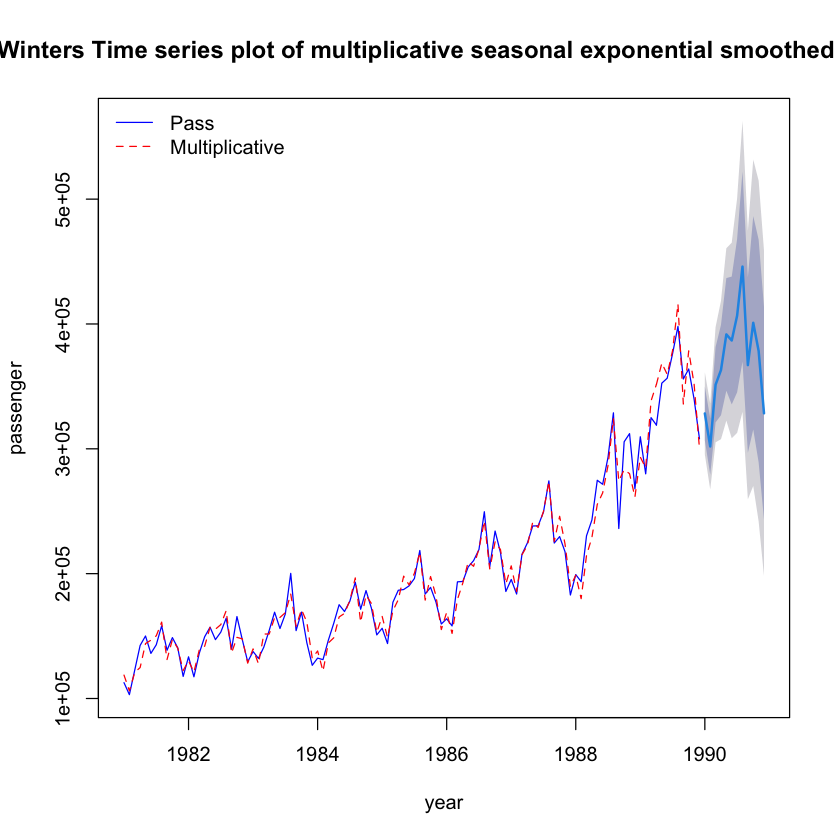

In [46]:
plot(fit7,  ylab="passenger", xlab="year", lty=1, col="blue",
     main="Winters Time series plot of multiplicative seasonal exponential smoothed data")
lines(fit7$fitted, col="red", lty=2)
legend("topleft", lty=1:2, col=c("blue","red"), c("Pass", "Multiplicative"),  bty = "n")

- 해석 : 가법모형에서는 예측 구간에서 앞에 있는 것을 붙여 놓은 것 마냥, 사실 분산이 점점 증가하고 있기에 예측 구간의 폭도 같이 늘어나야 하는데<br>
그렇지 못한 반면, 승법모형의 경우 분산이 커지는 것을 고려해서 진폭이 커지는 형태를 표현해준다.

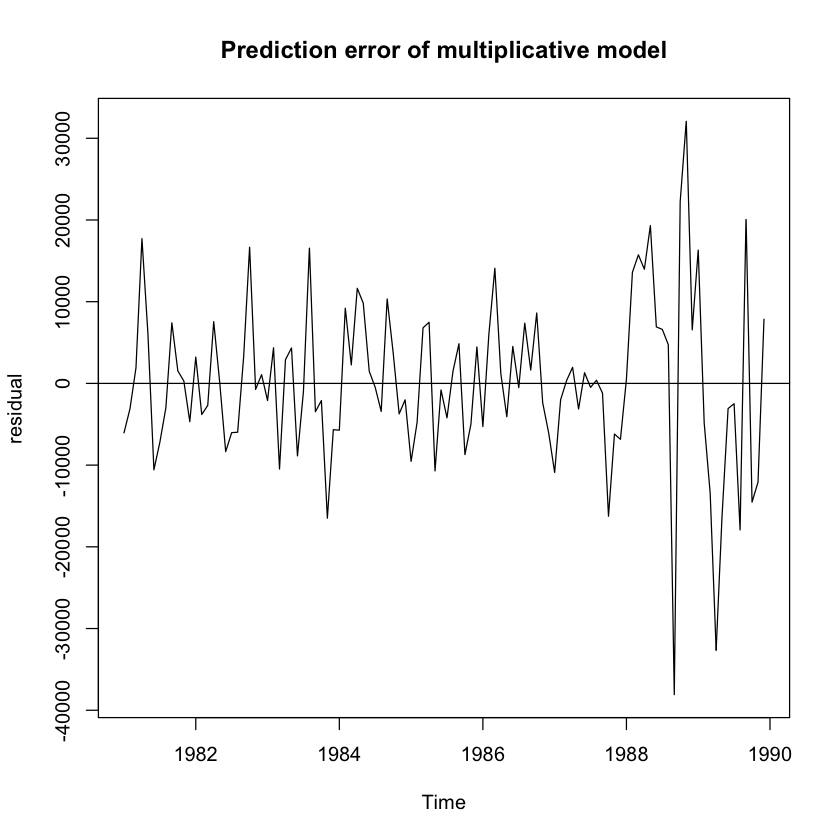

In [47]:
ts.plot(z-fit7$fitted, ylab="residual", 
        main="Prediction error of multiplicative model"); abline(h=0)

In [48]:
dwtest(lm(resid(fit7)~1), alternative = 'two.sided')


	Durbin-Watson test

data:  lm(resid(fit7) ~ 1)
DW = 1.6079, p-value = 0.03973
alternative hypothesis: true autocorrelation is not 0


### 결론

smoothing을 하려고 할 때 살펴 보아야 할 것<br>
level만 있다면 -> ses<br>
trend가 있다면 -> holt<br>
seasonality가 있다면 -> hw 그 중에서도 가법쓸 지, 승법 쓸 지